# CSCI-UA 0473 - Introduction to Machine Learning
## Wednesday, April 1, 2020

## Gameplan
Today we are going to do some dimensionality reduction for two different datasets.

In class, we covered two widely known types of techniques:

1. PCA = Principle Component Analysis
2. NMF = Non-negative Matrix Factorization


They differ in the kind of constraints we put on the code and dictionary matrices. 

### Libraries: some usual and not so usual suspects

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy import linalg

%matplotlib inline

### Random seed

In [2]:
np.random.seed(1)

## Dataset #1: Images
Dataset: greyscale faces of size 19x19

File 'svm.train.normgrey' avaialable to download from here: 
https://github.com/HyTruongSon/Pattern-Classification/blob/master/MIT-CBCL-database/svm.train.normgrey

In [3]:
! wget 'https://raw.githubusercontent.com/HyTruongSon/Pattern-Classification/master/MIT-CBCL-database/svm.train.normgrey' \
-O './svm.train.normgrey'

--2020-05-10 17:57:31--  https://raw.githubusercontent.com/HyTruongSon/Pattern-Classification/master/MIT-CBCL-database/svm.train.normgrey
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.208.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.208.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22483178 (21M) [text/plain]
Saving to: ‘./svm.train.normgrey’

./svm.train.normgre 100%[===================>]  21.44M  18.5MB/s    in 1.2s    

2020-05-10 17:57:34 (18.5 MB/s) - ‘./svm.train.normgrey’ saved [22483178/22483178]



### Read data

In [4]:
# Function to read the data
def read_data(data_path):
    """
    - Input: path to data file
    - Retuns: data array
    """
    raw_data = open(data_path).readlines()
    X = []
    for line in raw_data[2:]:
        if line.strip() == "":
            continue
        if int(line.split()[-1]) == -1:
            # not face, skip
            continue
        else:
            X.append( [float(yy) for yy in line.split()[:-1]] )
    
    X = np.array(X)
    X = X.transpose()
    print('Input data shape: {}'.format(X.shape))
    return X

# Read data
X_raw = read_data('svm.train.normgrey')

Input data shape: (361, 2429)


### Display Data

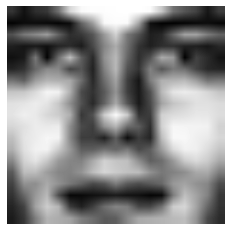

In [5]:
# Display data
plt.imshow(X_raw[:, 11].reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")
plt.axis("off")
plt.show()

## PCA Setup

Given data $X = [x_1; x_2; \ldots; x_N] \in \mathbb{R}^{d\times N}$, would like to represent it as: 

$X = W Z$

where $W\in \mathbb{R}^{d\times q}$ is a dictionary, $Z\in\mathbb{R}^{q\times N}$ are codes, $q\ll d$, and $ZZ^\top = \mathrm{diag}(\sigma_1^2, \ldots, \sigma_q^2)$, with $\sigma_1^2\geq \ldots \geq \sigma_q^2$.

__Procedure__

1. Center data: $x_n \leftarrow x_n - \frac{1}{N}\sum_{i=1}^N x_i $.

2. Scaled covariance: $C = XX^\top \in \mathbb{R}^{d\times d}$.

3. Eigendecomposition: $C = (W') \Sigma (W')^\top$ where $W', S\in\mathbb{R}^{d\times d}$, $W'$ is orthogonal, and $ \Sigma = \mathrm{diag}(\sigma_1^2, \ldots, \sigma_q^2)$.

4. Top $q$ principal components (first $q$ columns): $W \leftarrow W'_{(:, 1:q)}$.

5. Code vectors: $Z = W^\top X$.

__Equivalent Derivation using SVD__

Singular Value Decomposition for data $X\in\mathbb{R}^{d\times N}$ ($X$ should be __centered__ to match PCA solution):

$X = U S V$

where $U\in \mathbb{R}^{d\times d}$ and $V\in\mathbb{R}^{d\times N}$ are orthogonal matrices (namely, $U^\top U = I$ and $V^\top V = I$) and $S\in\mathbb{R}^{d\times d}$ is a diagonal matrix with decreasing (in absolute value) diagonal entries.

Note that:

$XX^\top = (U S V)( U S V)^\top  = U S V V^\top S^\top U^\top = U SS U^\top$

where $SS$ is a diagonal matrix $\mathrm{diag}(s_1^2, \ldots, s_d^2)$ with $s_1^2\geq \ldots \geq s_d^2$.

Then it must be the case that $U = W'$ and $SS = \Sigma$.

Therefore, SVD gives us a way to compute $W'$ without computing the covariance matrix $XX^\top$ which can be expensive for large $d$ and $N$.

### Center data

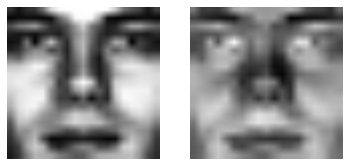

In [36]:
# Function to normalize the data
def center_data(data):
    """
    - Input: data array of size (data_dim x n_samples)
    - Retuns: centered data (mean subtracted from each data sample) of size (n_imgs x n_pixels)
    """
    mean = np.mean(data, axis=1)[:, None]
    centered_data = data - mean
    return centered_data, mean

# Display data before centering
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_raw[:, 11].reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")
axarr[0].axis("off")

# Center data
X, X_mean = center_data(X_raw)

# Split into training and validation
X, X_val = X[:, :2400], X[:, 2400:]

# Display data
axarr[1].imshow(X[:, 11].reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")
axarr[1].axis("off")
plt.show()

In [44]:
# Making sure that data dimensions match
(d, N) = X.shape
q = 121  # how many dimensions will be in the new space, aka # of components

print ("d: old dim",  d)
print ("N: num of samples", N)
print ("q: new dim", q)

d: old dim 361
N: num of samples 2400
q: new dim 121


### PCA using SVD 

__Recap__

Singular Value Decomposition: $X = W' S V$

where $W'\in \mathbb{R}^{d\times d}$ and $V\in\mathbb{R}^{d\times N}$ are orthogonal matrices, $S\in\mathbb{R}^{d\times d}$ is a diagonal matrix with decreasing (in absolute value) diagonal entries, and $XX^\top = W' SS(W')^{\top}$ is the eigendecomposition of the scaled covariance $XX^\top$.

In [45]:
def train_pca_svd(X):
    """
    Input: data of size (original_dim x n_samples)
    Output: SVD decomposition
    """
    W, S, V = linalg.svd(X)  
    print('Input dimensions: {}'.format(X.shape))
    print('Left singular vector matrix shape: {}'.format(W.shape))
    print('Singular value matrix shape: {}'.format(S.shape))
    print('Right singular vector matrix shape: {}'.format(V.shape))
        
    return W, S

In [46]:
# SVD decomposition
W_SVD, S = train_pca_svd(X)

Input dimensions: (361, 2400)
Left singular vector matrix shape: (361, 361)
Singular value matrix shape: (361,)
Right singular vector matrix shape: (2400, 2400)


### Principal Components

Dictionary $W$: top $q$ colums of $W'$, namely $W = [w'_1; \ldots; w'_q]\in \mathbb{R}^{d\times q}$, where $w'_i$ is the $i$-th column of $W'$.

In [47]:
# Take q most impactful columns from W_SVD
W = W_SVD[:, :q] 

### Visualization of principle components

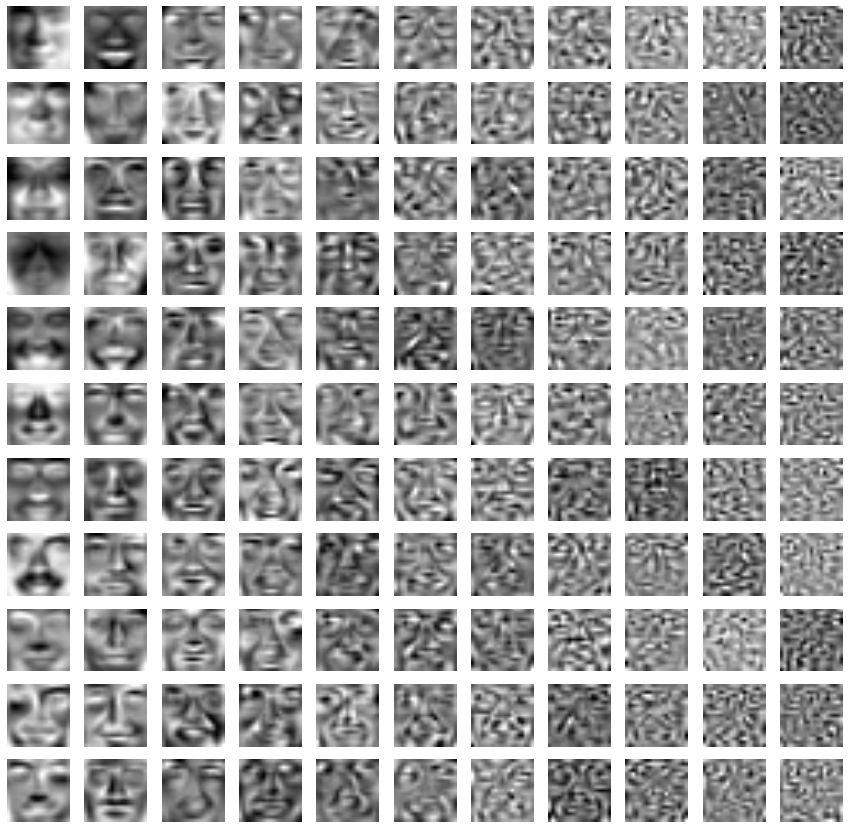

In [48]:
def viz_principle_comp(W):
    # Grid of $\sqrt{q}$ x $\sqrt{q}$ figures
    f, axarr = plt.subplots(int(np.sqrt(q)), int(np.sqrt(q)), figsize = (15, 15))
    
    # Display components
    comp_ix = 0
    for j in range(int(np.sqrt(q))):
        for i in range(int(np.sqrt(q))):
            axarr[i, j].imshow(W[: , comp_ix].reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")
            axarr[i, j].axis("off")
            comp_ix += 1

# Visualize principle components 
viz_principle_comp(W)

### Proportion of Variance Explained: PV
Given the singular value matrix $S$ the proportion of the variance in the data explained by the top $q$ principal components is:

$PV = \Big( \sum_{i=1}^q s_i^2\Big)/\Big(\sum_{i=1}^d s_i^2\Big)$

(also known as $R^2$)

In [12]:
pv = (S[:q]**2).sum()/(S**2).sum()
print('Proportion of Variance Explained: %.2f' % pv)

Proportion of Variance Explained: 0.97


### Dimensionality Reduction

Given the dictionary $W$, the codes are computed by: $Z = W^\top X$, where $Z\in\mathbb{R}^{q\times N}$.

In [13]:
# Reduce dimensionality of our input data
Z = W.transpose() @ X

In [14]:
# Sanity check
X.shape, Z.shape

((361, 2400), (121, 2400))

### Mean Squared Error: PCA

MSE = $\frac{1}{N}\|X - WZ\|_2^2$

In [15]:
# Mean squared error on training data
reconstruction_err = np.linalg.norm( X - W @ Z )/X.shape[1]
print ('Mean Squared Error (training): ', reconstruction_err)

Mean Squared Error (training):  0.0159090684190801


In [35]:
# Mean squared error on validation data
Z_val = W.transpose() @ X_val
print("here u go big boi :\n",curios)
reconstruction_err = np.linalg.norm( X_val - W @ Z_val )/X_val.shape[1]
print ('Mean Squared Error (unseen data): ', reconstruction_err)

here u go big boi :
 (121, 121)
Mean Squared Error (unseen data):  0.6732972761306404


### Reconstruct the image back from the reduced space

In [17]:
def reconstruct_face(X, Z, idx, norm_term=0):
    # Original and reconstruction 
    original_face = X[:,idx]
    reduced_face = Z[:,idx]
    reconstructed_face = W @ reduced_face
    
    # Map to input data space
    original_face += norm_term
    reconstructed_face += norm_term
    
    # Grid with original and reconstructed image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(original_face.reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed_face.reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")
    plt.axis("off")

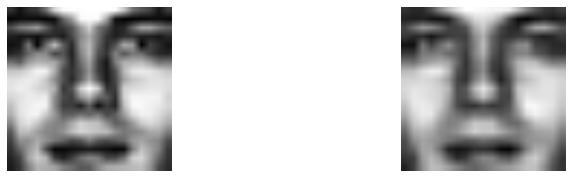

In [18]:
# Reconstruction of training data
reconstruct_face(X, Z, 11, X_mean.flatten())

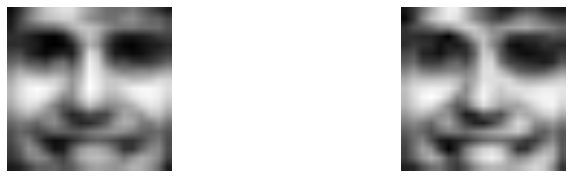

In [20]:
# Reconstruction of unseen data
reconstruct_face(X_val, Z_val, 11, X_mean.flatten())

# NMF factorization
Given __non-negative__ data $X = [x_1; x_2; \ldots; x_N] \in \mathbb{R}^{d\times N}$, represent it as: 

$X = W Z $

where $W\in \mathbb{R}^{d\times q}$ is a dictionary, $Z\in\mathbb{R}^{q\times N}$ are codes, $q\ll d$, and components of $W$ and $Z$ are __non-negative__.

There are many ways to compute $W$ and $Z$, two of them are specified below:

Reference: https://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf

__Multiplicative Update__

Update: 

$W = W (X Z^\top) / (W Z Z^\top)$

$Z = Z (W^\top X) / (W^\top W Z)$

Stack Exchange: https://stats.stackexchange.com/questions/351359/deriving-multiplicative-update-rules-for-nmf

__Projected Grdient Descent__

1) Greadient Descent Update:

$\tilde{W} = W - \eta \nabla_W (X - WZ) = W + \eta (X - WZ)  Z^\top$

$\tilde{Z} = Z - \eta \nabla_Z (X - WZ) = Z + \eta W^\top (X - WZ)$

2) Project back to feasible space (positive values):

$w_{ij} = \max(0, \tilde{w}_{ij})$

$z_{ij} = \max(0, \tilde{z}_{ij})$

### Data Preprocessing 

In [20]:
# Data pre-processing
X_min = np.min(X_raw)
X = X_raw - X_min # why do we do that?
X, X_val = X[:, :2400], X[:, 2400:]

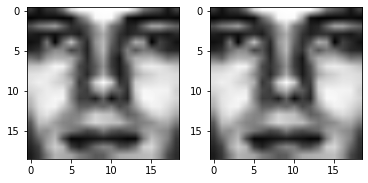

In [21]:
# Display data
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_raw[:, 11].reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")
axarr[1].imshow(X[:, 11].reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")
plt.show()

### Training

In [22]:
def train_nmf(input_data, multiplicative = False, lr = 0.0005, n_iter=1000, alpha=1e-3):    
    # X : (d, N)
    # W : (d, q)
    # Z : (q, N) 
    X = input_data
    d, N = X.shape
    W = np.real( (np.random.rand(d,q))*0.5 )
    Z = np.real( (np.random.rand(q,N))*0.5 )
    print ('start optimising...')
    
    for u_iter in range(n_iter):
        if multiplicative:
            # Multiplicative Update
            R = X - W @ Z
            W = W * (X @ np.transpose(Z)) / (W @ Z @ np.transpose(Z))
            Z = Z * (np.transpose(W) @ X) / (np.transpose(W) @ W @ Z)
        else:
            # Projected Gradient Descent
            R = X - W @ Z
            W_ = W + lr * R @ np.transpose(Z) - alpha * W # regularization term to encourage sparsity           
            Z_ = Z + lr * np.transpose(W) @ R     
            W, Z = np.maximum(W_, 0), np.maximum(Z_, 0)            

        if (u_iter + 1) % 100 == 1 or (u_iter + 1) == n_iter:
            print ('MSE ', u_iter + 1,":", np.linalg.norm(R)/N)
            # print('W 0s:', 1 - (W>0).sum()/(d*q), 'Z 0s:', 1 - (Z>0).sum()/(q*N))
        
    print ('optimisation finished')
    return W, Z

### NMF multiplicative update

In [23]:
# Learn NMF with multiplicative update
W, Z = train_nmf(X, multiplicative=True)

start optimising...
MSE  1 : 2.744810398563402
MSE  101 : 0.03629259778896408
MSE  201 : 0.02964957815404348
MSE  301 : 0.027371039443774142
MSE  401 : 0.026170289939390377
MSE  501 : 0.02540827471838311
MSE  601 : 0.024878181009386012
MSE  701 : 0.024474708338261614
MSE  801 : 0.024152787695326694
MSE  901 : 0.023885042724965114
MSE  1000 : 0.023660301901055506
optimisation finished


In [24]:
# Sanity check
(W < 0).sum(), (Z < 0).sum()

(0, 0)

### Visualize NMF with Multiplicative Update

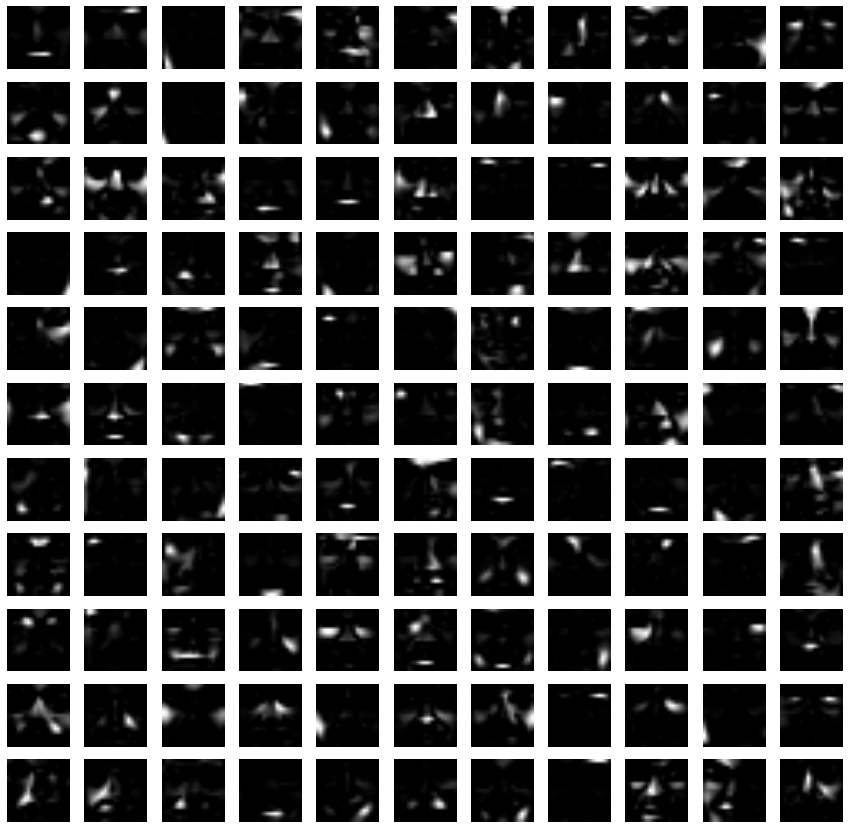

In [25]:
viz_principle_comp(W)

### Reconstruction

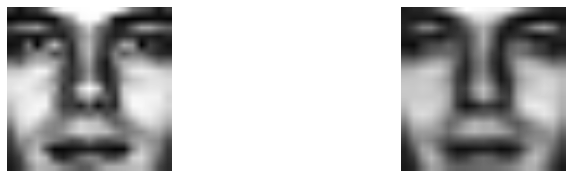

In [26]:
# Reconstruction of training data
reconstruct_face(X, Z, 11, X_min)

### NMF projected gradient descent

In [27]:
# Learn NMF with projected gradient update
W, Z = train_nmf(X, multiplicative=False, lr=5e-4, n_iter=2000, alpha=1e-5)

start optimising...
MSE  1 : 2.7508171246673823
MSE  101 : 0.07386361899158275
MSE  201 : 0.06005153928537455
MSE  301 : 0.0521888675118134
MSE  401 : 0.046771408833584896
MSE  501 : 0.0429011394033837
MSE  601 : 0.0400702598031398
MSE  701 : 0.03793301712013056
MSE  801 : 0.036280943467453246
MSE  901 : 0.03497808449520697
MSE  1001 : 0.03392956879598809
MSE  1101 : 0.03306894864424121
MSE  1201 : 0.03235109362853993
MSE  1301 : 0.031742689295125706
MSE  1401 : 0.03122170016129728
MSE  1501 : 0.030769332651665843
MSE  1601 : 0.030371788755521538
MSE  1701 : 0.03001959769502645
MSE  1801 : 0.029703942360693767
MSE  1901 : 0.029418903457102696
MSE  2000 : 0.029161419143450922
optimisation finished


In [28]:
# Sanity check
(W < 0).sum(), (Z < 0).sum()

(0, 0)

### Visualize NMF with Projected Gradient

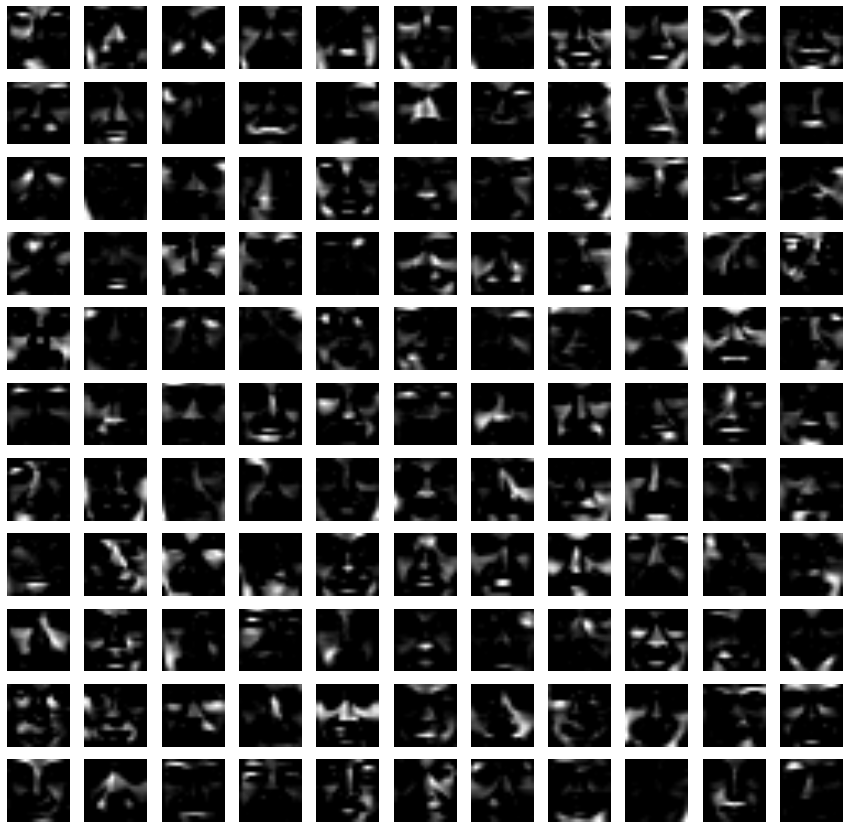

In [29]:
viz_principle_comp(W)

### Reconstruction

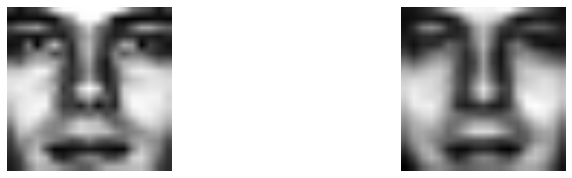

In [30]:
# Reconstruction of training data
reconstruct_face(X, Z, 11, X_min)

## Dataset #2 : Text
We are going to do dimensionality reduction for a subset of the 20 Newsgorups Dataset: 

http://qwone.com/~jason/20Newsgroups/

https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html


In [31]:
# 20 Newsgroups
from sklearn import datasets

newsgroups_train = datasets.fetch_20newsgroups(subset='train', 
                                               categories=['comp.graphics', 
                                                           'rec.motorcycles', 
                                                           'sci.space', 
                                                           'talk.politics.misc']
                                               )

X_raw = newsgroups_train.data
y = newsgroups_train.target
print('Corpus size: ', len(X_raw))
print('\nData sample\n:', X_raw[0])
print('\nTargets: ', np.unique(y))

Corpus size:  2240

Data sample
: From: jbreed@doink.b23b.ingr.com (James B. Reed)
Subject: Re: space news from Feb 15 AW&ST
Nntp-Posting-Host: doink
Reply-To: jbreed@ingr.com
Organization: Intergraph Electronics
Lines: 10

In article <C5ros0.uy@zoo.toronto.edu>, henry@zoo.toronto.edu (Henry Spencer) writes:
|> [Pluto's] atmosphere will start to freeze out around 2010, and after about
|> 2005 increasing areas of both Pluto and Charon will be in permanent
|> shadow that will make imaging and geochemical mapping impossible.

Where does the shadow come from?  There's nothing close enough to block
sunlight from hitting them.  I wouldn't expect there to be anything block
our view of them either.  What am I missing?

	Jim


Targets:  [0 1 2 3]


In [32]:
newsgroups_train.target_names

['comp.graphics', 'rec.motorcycles', 'sci.space', 'talk.politics.misc']

### Data Preprocessing
As a pre-processing step, we'll use the TF-IDF metric which stands for _term frequency-inverse document frequency_. 

It is used to measure how important a word $w$ is to a document $d$ in a collection or corpus of documents $D$, where $|D|=N$. 

Vanilla: 

$ \mathrm{tf}(t,d) = $ # times $t$ appears in $d$

$\mathrm{idf}(t,D) = \log\frac{N}{|d\in D: t\in d|}$

$\mathrm{TF-IDF}(t,d,D ) = \mathrm{tf}(t,d)\cdot\mathrm{idf}(t,D)$

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
    
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(min_df=30)
X_vec = tfidf_vectorizer.fit_transform(X_raw).toarray()

X_vec = X_vec.transpose()
print("Vectorized data shape:", X_vec.shape)

# Center data 
X, X_mean = center_data(X_vec)

Vectorized data shape: (1845, 2240)


### PCA 

In [34]:
# Sanity check
(d, N) = X.shape
q = 100  # our reduced dimension

print ("d: old dim",  d)
print ("N: num of samples", N)
print ("q: new dim", q)

d: old dim 1845
N: num of samples 2240
q: new dim 100


In [35]:
W_SVD, S = train_pca_svd(X)

Input dimensions: (1845, 2240)
Left singular vector matrix shape: (1845, 1845)
Singular value matrix shape: (1845,)
Right singular vector matrix shape: (2240, 2240)


In [36]:
# Take q most impactful columns from W
W = W_SVD[:, :q]

# Reduce dimensionality of our input data
Z = W.transpose() @ X
Z.shape

(100, 2240)

### Visualization of principle components: PCA

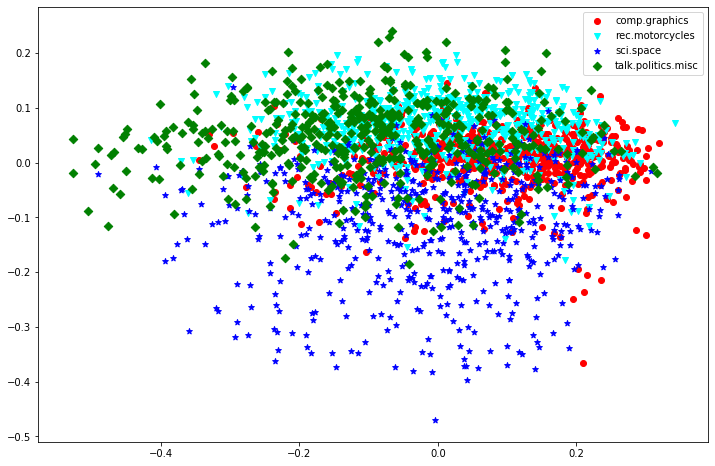

In [37]:
plt.figure(figsize=(12, 8))
colors = ['red', 'aqua', 'blue', 'green']
markers = ['o', 'v', '*', 'D']
for label in np.unique(y):
    idx = np.where(y == label)
    plt.scatter(Z[0][idx], Z[1][idx], c = colors[label], marker=markers[label], label=newsgroups_train.target_names[label])
plt.legend(loc='best')
plt.show()
# first one is length, second one is where the topics start to show , check if tf-idf is normalized by the length 

### Highest-weighted tokens across dictionary

In [38]:
dictionary = dict([(vv,kk) for kk, vv in tfidf_vectorizer.vocabulary_.items()])
insens_idx = np.argsort(W[:, 0])

print ('Top 10 most activated words')
for jj in insens_idx[-10:]:
    print ('{} ({:0.6f})'.format(dictionary[jj], W[jj, 0]))
           
    
print ('\nTop 10 least activated words')
for jj in insens_idx[:10]:
    print ('{} ({:0.6f})'.format(dictionary[jj], W[jj, 0]))

Top 10 most activated words
organization (0.051792)
posting (0.053530)
nntp (0.053733)
university (0.054075)
host (0.054184)
subject (0.055557)
lines (0.055600)
thanks (0.063306)
graphics (0.064202)
edu (0.080082)

Top 10 least activated words
the (-0.594649)
to (-0.261940)
of (-0.223208)
and (-0.207041)
that (-0.202946)
is (-0.146048)
in (-0.134450)
it (-0.131069)
you (-0.125405)
was (-0.103043)


### Reconstruction Error

In [39]:
reconstruction_err = np.linalg.norm( X - W @ Z )/ X.shape[1]
print ('MSE error: ', reconstruction_err)

MSE error:  0.015371123085262346


### Proportion of Variance Explained: PV

In [40]:
pv = (S[:q]**2).sum()/(S**2).sum()
print('Proportion of Variance Explained: %.2f' % pv)

Proportion of Variance Explained: 0.39


### NMF 

In [41]:
# Data preprocessing
X_min = np.min(X_vec)
X = X_vec - X_min  # why do we do that?

# NMF
W, Z = train_nmf(X, multiplicative=True, n_iter=500)

start optimising...
MSE  1 : 5.689997841317967
MSE  101 : 0.01605860049485042
MSE  201 : 0.016007713301264645
MSE  301 : 0.01598905521123251
MSE  401 : 0.015977067773988596
MSE  500 : 0.015970448686881505
optimisation finished


In [42]:
W.shape, Z.shape

((1845, 100), (100, 2240))

### Highest-weighted tokens across dictionary

In [43]:
# Dictionary of words
dictionary = dict([(vv,kk) for kk, vv in tfidf_vectorizer.vocabulary_.items()])

# Display most active words in each component
for i in range(q):
    insens_idx = np.argsort(W[:, i])

    print ('COMPONENT ' + str(i))
    print (' '.join([dictionary[w_ix] for w_ix in insens_idx[-10:]]) + '\n')

COMPONENT 0
high such michael adams jacked edu acad3 nsmca aurora alaska

COMPONENT 1
really au during this visible light night oz sky research

COMPONENT 2
vax instruments real mary don speak com fred dseg ti

COMPONENT 3
satellite at model 50 launch are 000 rocket of rockets

COMPONENT 4
uunet uucp internet department university astronomy edu va greg virginia

COMPONENT 5
general and for rule after hours drinking ride riding drink

COMPONENT 6
with think about not on just do like but it

COMPONENT 7
country in care university edu ryan acs magnus state ohio

COMPONENT 8
live 85 ny york reply robert gary edu columbia cc

COMPONENT 9
ac them will waste edu william nuclear oil paul rochester

COMPONENT 10
richard in reality air division md tom army navy mil

COMPONENT 11
all chris posts per groups of group this newsgroup umich

COMPONENT 12
this surface double algorithm plane point nl radius center points

COMPONENT 13
government this those to not or are their who people

COMPONENT 14
pr

### Reconstruction error: NMF

In [44]:
# Squared error
reconstruction_err = np.linalg.norm(X - W @ Z)/X.shape[1]
print ('MSE error: ', reconstruction_err)

MSE error:  0.015970398994436717


## Your HW assignment: do PCA and NMF for text using sklearn!

## Bonus: Gaussian Processes Latent Variable Model (GPLVM)

From previous lab, we now that a **Gaussian Process** (GP) is defined by:

$f(\mathbf{x})\sim \mathcal{GP}\left(\mathbf{0}, K\right)$ 

where $K$ is a kernel matrix $K= k(\mathbf{z}, \mathbf{z'})$.

### GPLVM

__Dimensionality Reduction Technique__

- Assumes the observed data $X = [x_1; x_2; \ldots; x_N] \in \mathbb{R}^{d\times N}$ is generated from a lower dimensional __latent__ (unobserved) data $Z\in \mathbb{R}^{q\times N}$ 

- Generation process $\mathbf{x}_i = f(\mathbf{z}_i) + \varepsilon$, where $\varepsilon \sim \mathcal{N}(0, \sigma^2)$ and $f$ is a non-linear function with GP prior $f(\mathbf{z})\sim \mathcal{GP}\left(\mathbf{0}, K\right)$

GPLVM as a Directed Graph

![title](https://i.imgur.com/5GdA2KE.png)

The marginal likelihood is obtained by integrating $f$ and using Bayes' Theorem:

$p(X | Z, \theta) =  \prod_{i=1}^d \mathcal{N} (\mathbf{x}^{(i)} | 0, K ) = \prod_{i=1}^d \frac{1}{(2\pi)^{0.5} |K|^{0.5}}\exp\Big(-0.5 (\mathbf{x}^{(i)})^{\top} K^{-1}\mathbf{x}^{(i)}\Big)$

where $x^{(i)}$ is the $i$-th row of $X$.

__Extension of Probabilistic PCA__

- $W$ follows a Gaussian distribution prior: $p(W) = \prod_{i=1}^d (\mathbf{w}_i | 0, I)$

- The marginal likelihood is: $p(X | Z, \alpha) = \int p(X | WZ, \alpha) p(W)\,dW = \prod_{i=1}^d \mathcal{N} (\mathbf{x}^{(i)} | 0, ZZ^T + \alpha^{-1}I)$ 

Original paper: https://papers.nips.cc/paper/2540-gaussian-process-latent-variable-models-for-visualisation-of-high-dimensional-data.pdf

Helpful Overview: https://www.sciencedirect.com/science/article/pii/S2468232216300828

Sample tutorial: https://pyro.ai/examples/gplvm.html